In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 11
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)

trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

#train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, not_nn_loss_weight=100)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each


In [5]:
from copy import deepcopy
from random import random
import torch as T
import torch.nn.functional as F
import numpy as np

top = deepcopy(trained_reasoner.top_concept)
bot = deepcopy(trained_reasoner.bot_concept)
sub_nn = deepcopy( trained_reasoner.sub_nn)
and_nn = deepcopy(trained_reasoner.and_nn)
not_nn = deepcopy(trained_reasoner.not_nn)

optimizer = T.optim.AdamW([{'params': and_nn.parameters()},
                           {'params': sub_nn.parameters()},
                           {'params': not_nn.parameters()},
                           {'params': top},
                           {'params': bot}
                           ], 0.0001)

losses = []
for i in range(16001):
    optimizer.zero_grad()

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input3 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    loss = F.mse_loss(input1, and_nn(im_mod(input1, input1)))
    loss += F.mse_loss(input2, and_nn(im_mod(input2, input2)))
    loss += F.mse_loss(input3, and_nn(im_mod(input3, input3)))

    loss += F.mse_loss(and_nn(im_mod(input1, and_nn(im_mod(input2, input3)))), and_nn(im_mod(and_nn(im_mod(input1, input2)), input3)))
    loss += F.mse_loss(and_nn(im_mod(input2, and_nn(im_mod(input1, input3)))), and_nn(im_mod(and_nn(im_mod(input1, input2)), input3)))
    loss += F.mse_loss(and_nn(im_mod(input3, and_nn(im_mod(input1, input2)))), and_nn(im_mod(and_nn(im_mod(input3, input2)), input1)))

    loss += F.mse_loss(and_nn(im_mod(input1, input3)), and_nn(im_mod(input3, input1)))
    loss += F.mse_loss(and_nn(im_mod(input3, input2)), and_nn(im_mod(input2, input3)))
    loss += F.mse_loss(and_nn(im_mod(input2, input1)), and_nn(im_mod(input1, input2)))

    loss += F.mse_loss(bot[0], and_nn(im_mod(input1, not_nn(input1))))
    loss += F.mse_loss(bot[0], and_nn(im_mod(input2, not_nn(input2))))
    loss += F.mse_loss(bot[0], and_nn(im_mod(input1, not_nn(input1))))

    loss += F.mse_loss(input1, and_nn(im_mod(input1, top[0])))
    loss += F.mse_loss(input2, and_nn(im_mod(top[0], input2)))
    loss += F.mse_loss(input3, and_nn(im_mod(input3, top[0])))

    loss += F.mse_loss(bot[0], and_nn(im_mod(input1, bot[0])))
    loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input2)))
    loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input3)))
    loss += F.mse_loss(bot[0], and_nn(im_mod(top[0], bot[0])))

    loss += (1 - T.sigmoid(sub_nn(im_mod(input1, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input2, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input3, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], top[0])))).sum()

    loss += (1 - T.sigmoid(sub_nn(im_mod(input1, input1)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input2, input2)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input3, input3)))).sum()

    loss += T.sigmoid(sub_nn(im_mod(input1, bot[0]))).sum()
    loss += T.sigmoid(sub_nn(im_mod(input2, bot[0]))).sum()
    loss += T.sigmoid(sub_nn(im_mod(input3, bot[0]))).sum()

    loss += F.mse_loss(bot[0], not_nn(top[0]))
    loss += F.mse_loss(top[0], not_nn(bot[0]))

    loss += F.mse_loss(input1, not_nn(not_nn(input1)))
    loss += F.mse_loss(input2, not_nn(not_nn(input2)))
    loss += F.mse_loss(input3, not_nn(not_nn(input3)))

    losses.append(loss.item())

    if i % 800 == 0:
        print("loss: ", loss.item())

    loss.backward()
    optimizer.step()


loss:  6.508798122406006


KeyboardInterrupt: 

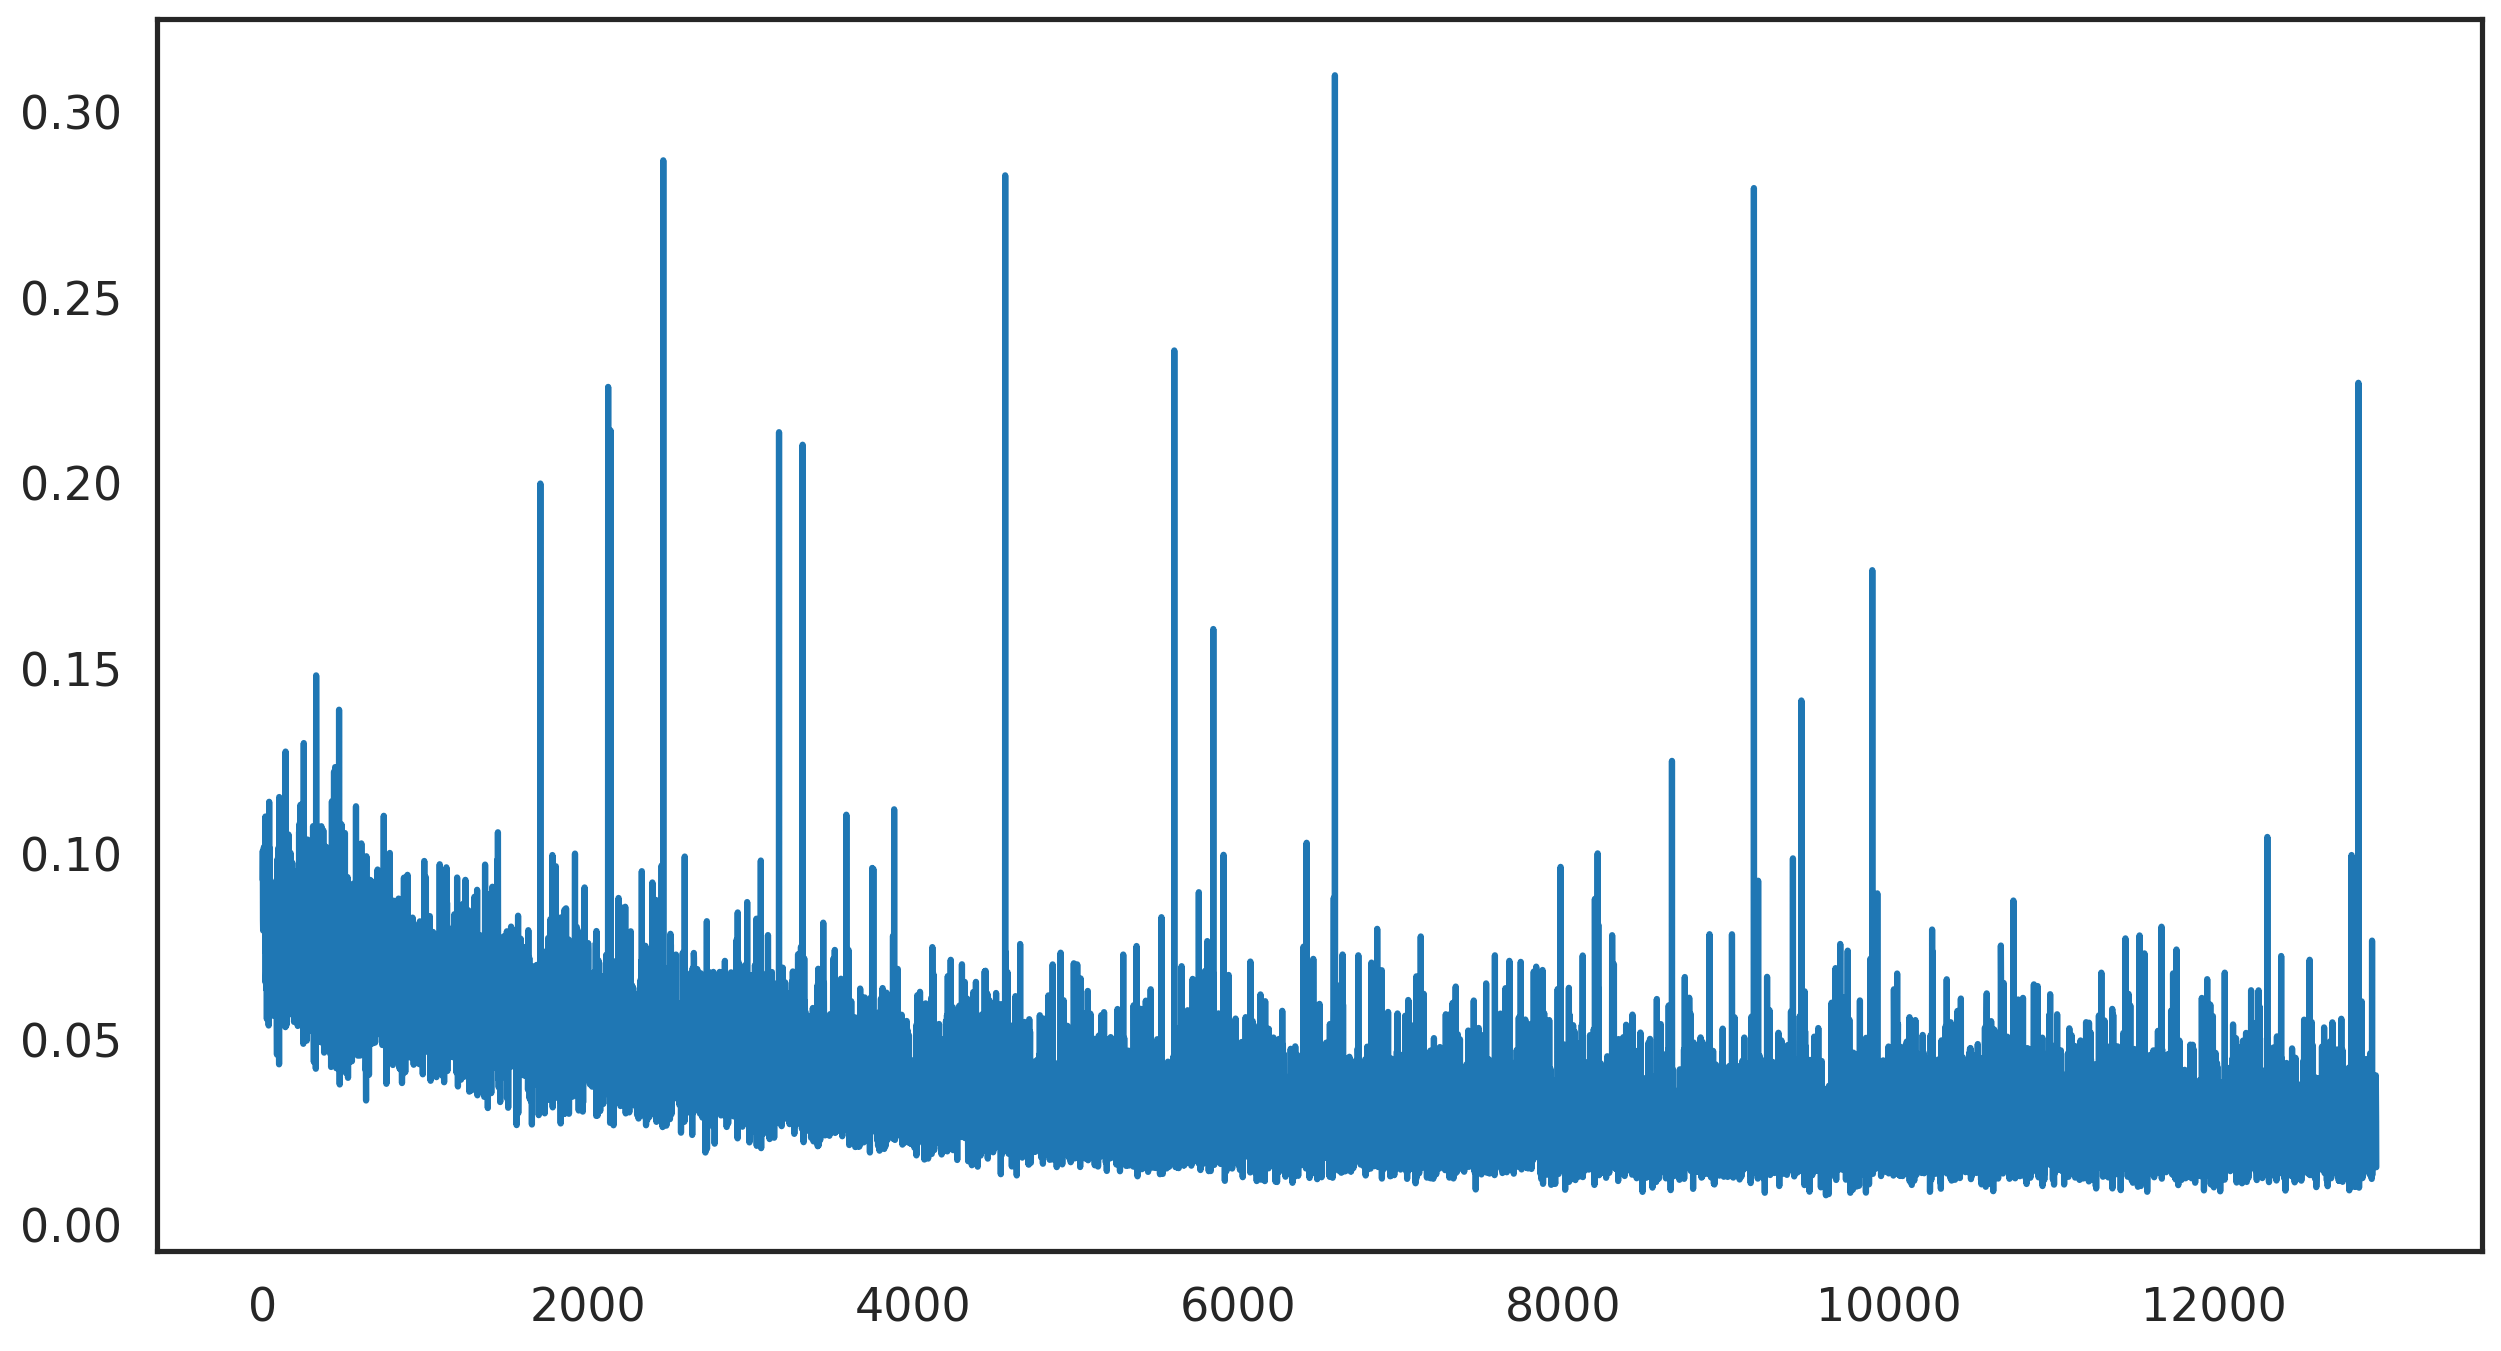

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses[7000:])

In [ ]:
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=4, batch_size=batch_size, not_nn_loss_weight=100, top_bot_weight=18, and_nn_loss_weight=40, train_top_bot=True, sub_weight=1.6)

train epoch 0/4 | batch 2001/2000 | loss 18.5318 | val loss 2.1643 | acc 0.8375 | f1 0.3956 | prec 0.9540 | recall 0.2496 | roc auc 0.6759 | pr auc 0.5037 | elapsed 159.88s
train epoch 1/4 | batch 2001/2000 | loss 16.7130 | val loss 0.2406 | acc 0.9281 | f1 0.8239 | prec 0.8614 | recall 0.7894 | roc auc 0.9426 | pr auc 0.8982 | elapsed 182.71s
train epoch 2/4 | batch 2001/2000 | loss 14.9756 | val loss 0.2192 | acc 0.9317 | f1 0.8317 | prec 0.8755 | recall 0.7921 | roc auc 0.9469 | pr auc 0.9063 | elapsed 178.60s
train epoch 3/4 | batch 2001/2000 | loss 14.3022 | val loss 0.2111 | acc 0.9351 | f1 0.8389 | prec 0.8912 | recall 0.7924 | roc auc 0.9495 | pr auc 0.9113 | elapsed 177.85s
train epoch 4/4 | batch 2001/2000 | loss 14.0737 | val loss 0.2078 | acc 0.9363 | f1 0.8432 | prec 0.8870 | recall 0.8035 | roc auc 0.9514 | pr auc 0.9148 | elapsed 178.18s


In [ ]:
torch.set_printoptions(precision=3)
input = T.rand(10)
print(input)
output = trained_reasoner.not_nn(trained_reasoner.not_nn(input))
print(output)
print(F.mse_loss(input, output))

tensor([0.365, 0.006, 0.083, 0.739, 0.244, 0.154, 0.551, 0.959, 0.119, 0.466])
tensor([0.362, 0.004, 0.081, 0.740, 0.243, 0.153, 0.552, 0.958, 0.119, 0.467],
       grad_fn=<SqueezeBackward3>)
tensor(1.674e-06, grad_fn=<MseLossBackward0>)


In [ ]:
print(T.round(T.matmul( trained_reasoner.not_nn.weight, trained_reasoner.not_nn.weight)*100)/100)

tensor([[1.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000,
         0.0000],
        [-0.0000, 1.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000,
         -0.0000],
        [0.0000, -0.0000, 1.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
         -0.0000],
        [-0.0000, 0.0000, 0.0000, 1.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000,
         0.0000],
        [0.0000, -0.0000, -0.0000, -0.0000, 1.0000, -0.0000, 0.0000, 0.0000, 0.0000,
         -0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 1.0000, -0.0000, -0.0000, -0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0100, 0.0000, -0.0000, 0.0000, 1.0000, -0.0000, -0.0000,
         0.0000],
        [0.0000, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000, 1.0000, 0.0000,
         0.0000],
        [-0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 1.0000,
         0.0000],
        [-0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000, -0.0000, -0

In [ ]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.694,  0.159,  0.212, -0.369,  0.660, -0.021,  0.159,  0.191, -0.352,
        -0.401], grad_fn=<SelectBackward0>)
tensor([ 0.582,  0.156,  0.104, -0.401,  0.599, -0.122,  0.197,  0.080, -0.415,
        -0.345], grad_fn=<SqueezeBackward3>)
tensor(0.006, grad_fn=<MseLossBackward0>)


In [ ]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.050, -0.440, -0.217,  0.344,  0.334,  0.293,  0.991,  0.282, -0.365,
         0.323], grad_fn=<SelectBackward0>)
tensor([ 0.114, -0.334, -0.134,  0.336,  0.292,  0.265,  1.000,  0.385, -0.255,
         0.259], grad_fn=<SqueezeBackward3>)
tensor(0.005, grad_fn=<MseLossBackward0>)


In [ ]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger, not_nn_loss_weight=0.1)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1251/1250 | loss 1.1755 | val loss 1.1755 | acc 0.6637 | f1 0.3946 | prec 0.3242 | recall 0.5041 | roc auc 0.6483 | pr auc 0.4835 | elapsed 20.10s
train epoch 01/10 | batch 1251/1250 | loss 0.9989 | val loss 0.7894 | acc 0.7421 | f1 0.4734 | prec 0.4257 | recall 0.5331 | roc auc 0.7296 | pr auc 0.5584 | elapsed 40.54s
train epoch 02/10 | batch 1251/1250 | loss 0.6748 | val loss 0.5319 | acc 0.8112 | f1 0.5728 | prec 0.5636 | recall 0.5823 | roc auc 0.8109 | pr auc 0.6590 | elapsed 40.27s
train epoch 03/10 | batch 1251/1250 | loss 0.4670 | val loss 0.3755 | acc 0.8632 | f1 0.6715 | prec 0.7024 | recall 0.6433 | roc auc 0.8751 | pr auc 0.7603 | elapsed 44.74s
train epoch 04/10 | batch 1251/1250 | loss 0.3411 | val loss 0.2815 | acc 0.8990 | f1 0.7520 | prec 0.8060 | recall 0.7048 | roc auc 0.9175 | pr auc 0.8369 | elapsed 46.06s
train epoch 05/10 | batch 1251/1250 | loss 0.2644 | val loss 0.2232 | acc 0.9211 | f1 0.8055 | prec 0.8683 | recall 0.

In [ ]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240707T155617


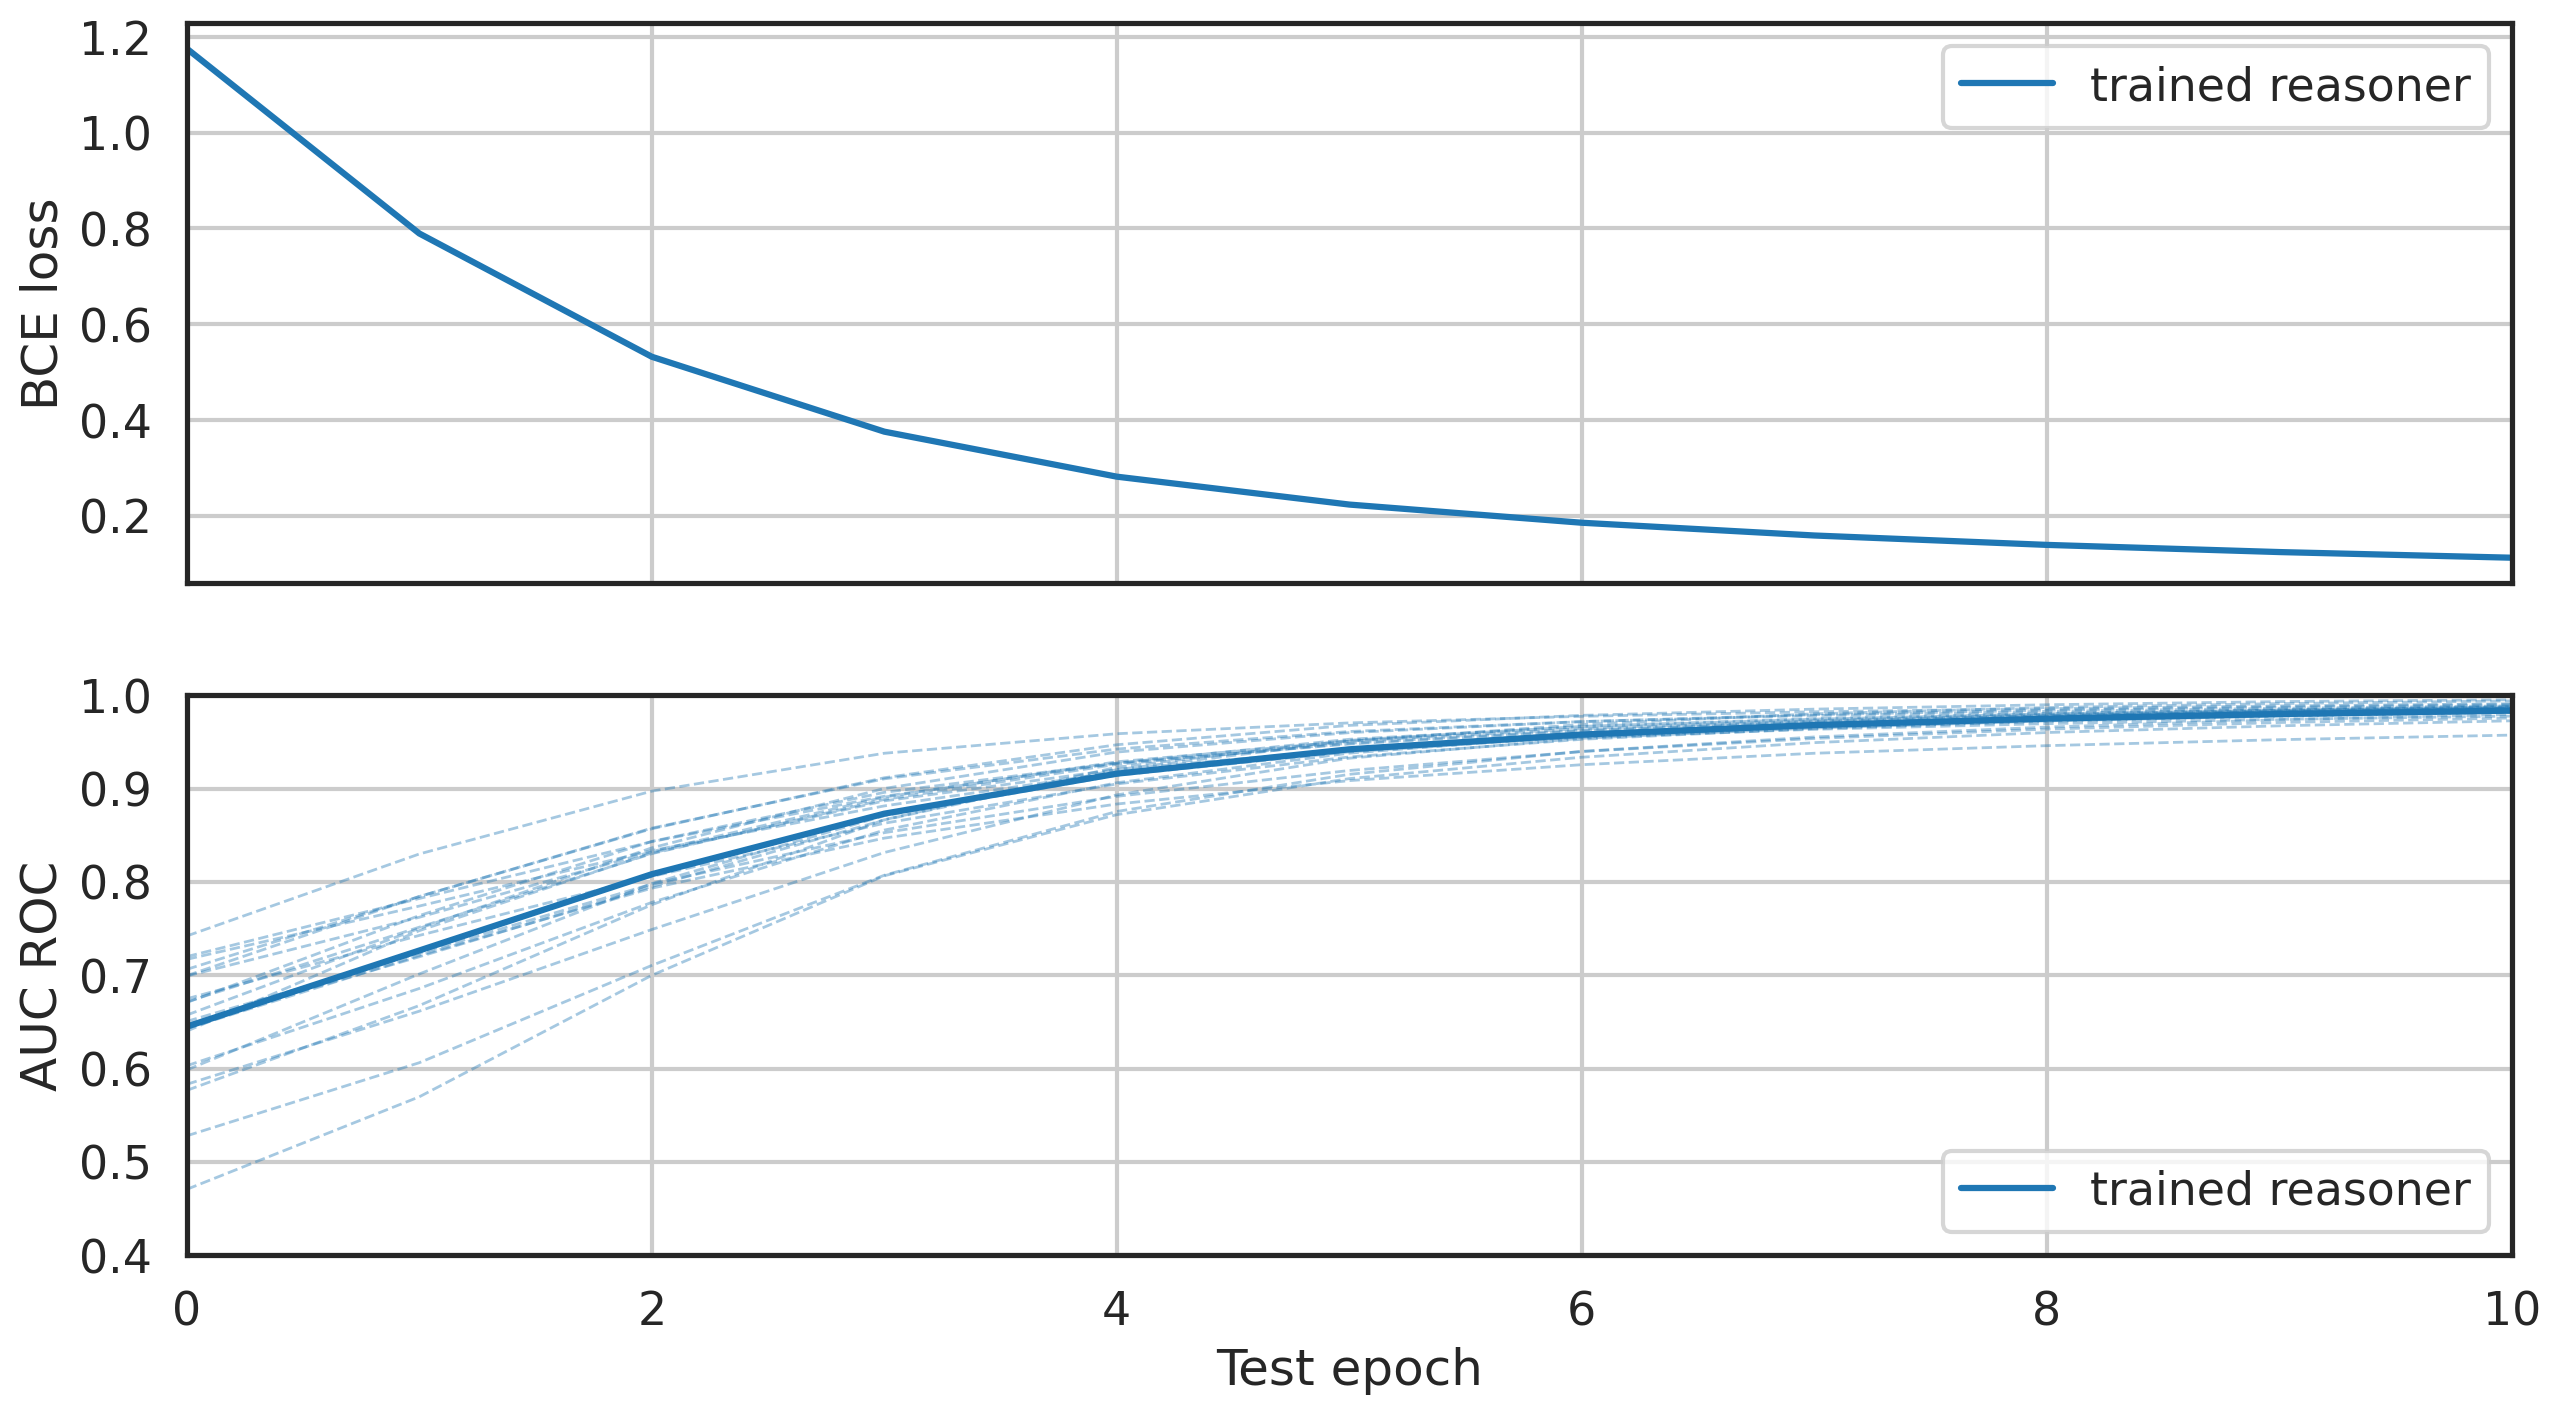

             mean       std     micro
acc      0.961800  0.015833  0.961800
prec     0.957149  0.030061  0.957260
recall   0.860902  0.046225  0.862810
f1       0.906234  0.037480  0.907584
auc_roc  0.983472  0.008500  0.984408
auc_pr   0.963084  0.017698  0.965479


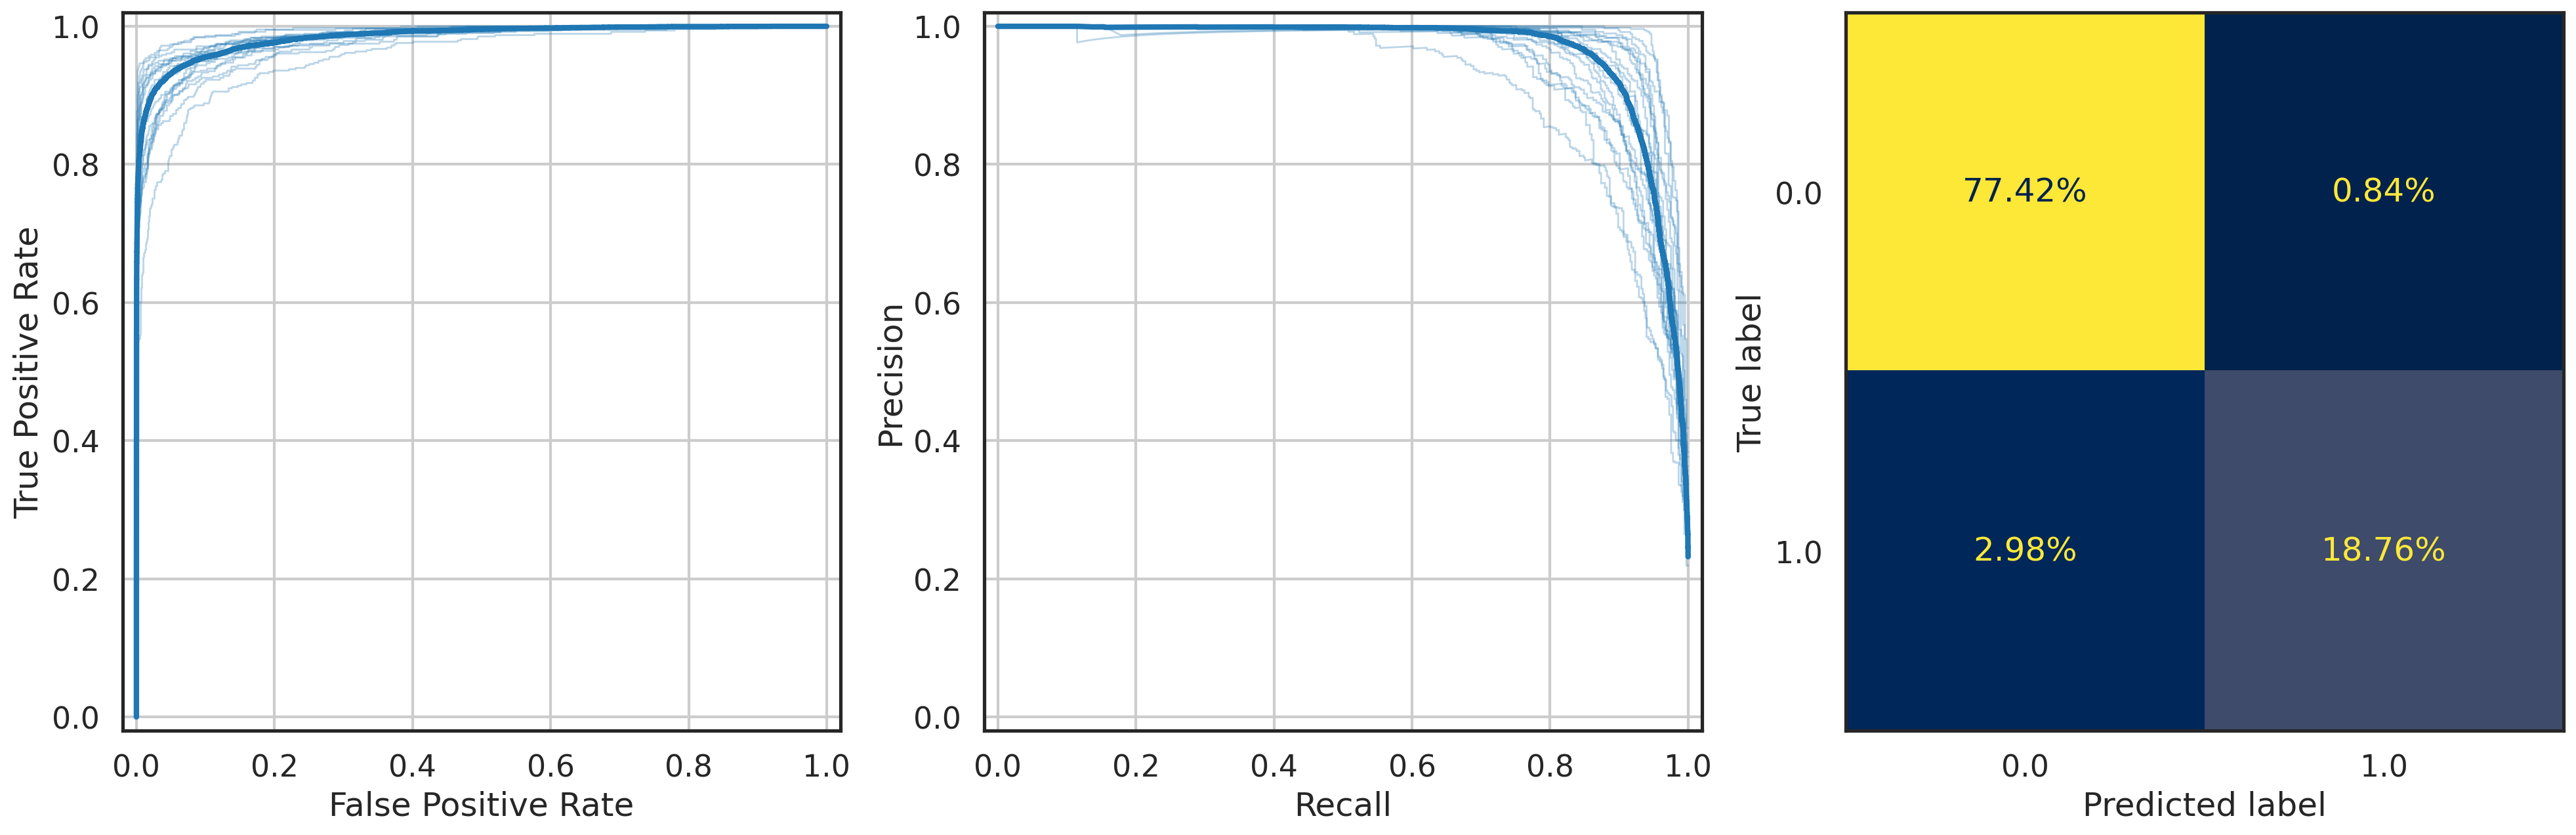

In [ ]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [ ]:
trained_reasoner.load_state_dict(torch.load('local/out/exp/20240707T155617/reasoner.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'local/out/exp/20240707T155617/reasoner.pt'

In [ ]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te = np.array(Y_te_good)
y_te = np.array(y_te)
X_te = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te - y_te) > 0.5

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te[błędne_predykcje],
    'Predykcja': Y_te[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

/tmp/ipykernel_14807/2895476319.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_te = np.array(X_te)


In [ ]:
from tabulate import tabulate
print(tabulate(wyniki, headers='keys', tablefmt='pipe', showindex=False))


|   Rekord |   Prawdziwa Etykieta |   Predykcja |   Feature_0 | Feature_1                       | Feature_2    |
|---------:|---------------------:|------------:|------------:|:--------------------------------|:-------------|
|       35 |                    1 | 0.112408    |           2 | 36                              | 77           |
|      113 |                    1 | 0.46113     |           0 | 114                             | 86           |
|      135 |                    1 | 0.196787    |           2 | 104                             | 61           |
|      184 |                    1 | 0.0251049   |           2 | 2                               | 109          |
|      344 |                    1 | 0.214197    |           0 | (6, 0, (3, 47))                 | 40           |
|      361 |                    1 | 0.032271    |           2 | 57                              | 71           |
|      413 |                    1 | 0.0397884   |           0 | 42                              

In [ ]:
input = T.rand(10)

print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
F.mse_loss(input, trained_reasoner.and_nn(im_mod(input, input)))

tensor([0.3896, 0.3885, 0.3615, 0.8075, 0.5779, 0.4344, 0.0655, 0.9872, 0.0299,
        0.0999])
tensor([ 0.5866,  0.3172, -0.1094, -0.2132, -0.2025,  0.2189,  0.7606,  0.3294,
         0.0561, -0.3491], grad_fn=<AddBackward0>)


tensor(0.3081, grad_fn=<MseLossBackward0>)

In [ ]:
input = T.rand(10)

print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(F.mse_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]))

tensor([ 0.5155,  0.3159,  0.0103, -0.5159,  0.4638, -0.1788,  0.2240,  0.1930,
        -0.5316, -0.3215], grad_fn=<SelectBackward0>)
tensor([ 0.3333,  0.5296, -0.3235, -0.4501,  0.0463,  0.1833,  0.4908,  0.2588,
        -0.4396, -0.4536], grad_fn=<AddBackward0>)
tensor(0.0601, grad_fn=<MseLossBackward0>)


In [ ]:
input = T.rand(10)

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(F.mse_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input))


tensor([0.6216, 0.0946, 0.2212, 0.0317, 0.3876, 0.3637, 0.9867, 0.5766, 0.3706,
        0.8221])
tensor([ 0.3540, -0.1454,  0.0116,  0.2724, -0.5946,  0.3433,  0.8309,  0.2040,
         0.5754, -0.0161], grad_fn=<AddBackward0>)
tensor(0.2104, grad_fn=<MseLossBackward0>)


In [ ]:
input = T.rand(10)

print(trained_reasoner.bot_concept[0])
output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
print(output)
print(F.mse_loss(output, input))


tensor([ 0.5155,  0.3159,  0.0103, -0.5159,  0.4638, -0.1788,  0.2240,  0.1930,
        -0.5316, -0.3215], grad_fn=<SelectBackward0>)
tensor([ 0.2059,  0.3115, -0.2408, -0.3118, -0.2161,  0.5378,  0.9224, -0.0611,
        -0.1828, -0.6828], grad_fn=<AddBackward0>)
tensor(0.5216, grad_fn=<MseLossBackward0>)


In [ ]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.5155,  0.3159,  0.0103, -0.5159,  0.4638, -0.1788,  0.2240,  0.1930,
        -0.5316, -0.3215], grad_fn=<SelectBackward0>)
tensor([ 0.5901,  0.4253, -0.0456, -0.6415,  0.5297, -0.2324,  0.3255,  0.1877,
        -0.5745, -0.4048], grad_fn=<SqueezeBackward3>)
tensor(0.0063, grad_fn=<MseLossBackward0>)


In [ ]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.0437, -0.3024, -0.0722,  0.6900,  0.1729,  0.2330,  1.1651,  0.5745,
        -0.2052,  0.2727], grad_fn=<SelectBackward0>)
tensor([ 0.0429, -0.2524, -0.0547,  0.5535,  0.0658,  0.1214,  0.9758,  0.4940,
        -0.1495,  0.2209], grad_fn=<SqueezeBackward3>)
tensor(0.0093, grad_fn=<MseLossBackward0>)


In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
    
    def forward(self, y_true, y_pred):
        # Krok 1: Obliczanie wartości bezwzględnej różnicy
        abs_diff = torch.abs(y_true - y_pred)
        
        # Krok 2: Zastosowanie funkcji softmax
        softmax_values = F.softmax(abs_diff, dim=-1)
        
        # Krok 3: Mnożenie wyniku softmax przez wartość bezwzględną różnicy
        result = softmax_values * abs_diff
        
        # Zwracanie średniej wartości jako stratę
        return result.mean()

loss:  tensor(0.0372, grad_fn=<AddBackward0>)
loss:  tensor(0.0291, grad_fn=<AddBackward0>)
loss:  tensor(0.0368, grad_fn=<AddBackward0>)
loss:  tensor(0.0267, grad_fn=<AddBackward0>)
loss:  tensor(0.0270, grad_fn=<AddBackward0>)
loss:  tensor(0.0289, grad_fn=<AddBackward0>)
loss:  tensor(0.0325, grad_fn=<AddBackward0>)
loss:  tensor(0.0275, grad_fn=<AddBackward0>)
loss:  tensor(0.0212, grad_fn=<AddBackward0>)
loss:  tensor(0.0218, grad_fn=<AddBackward0>)
loss:  tensor(0.0347, grad_fn=<AddBackward0>)
loss:  tensor(0.0431, grad_fn=<AddBackward0>)
loss:  tensor(0.0398, grad_fn=<AddBackward0>)


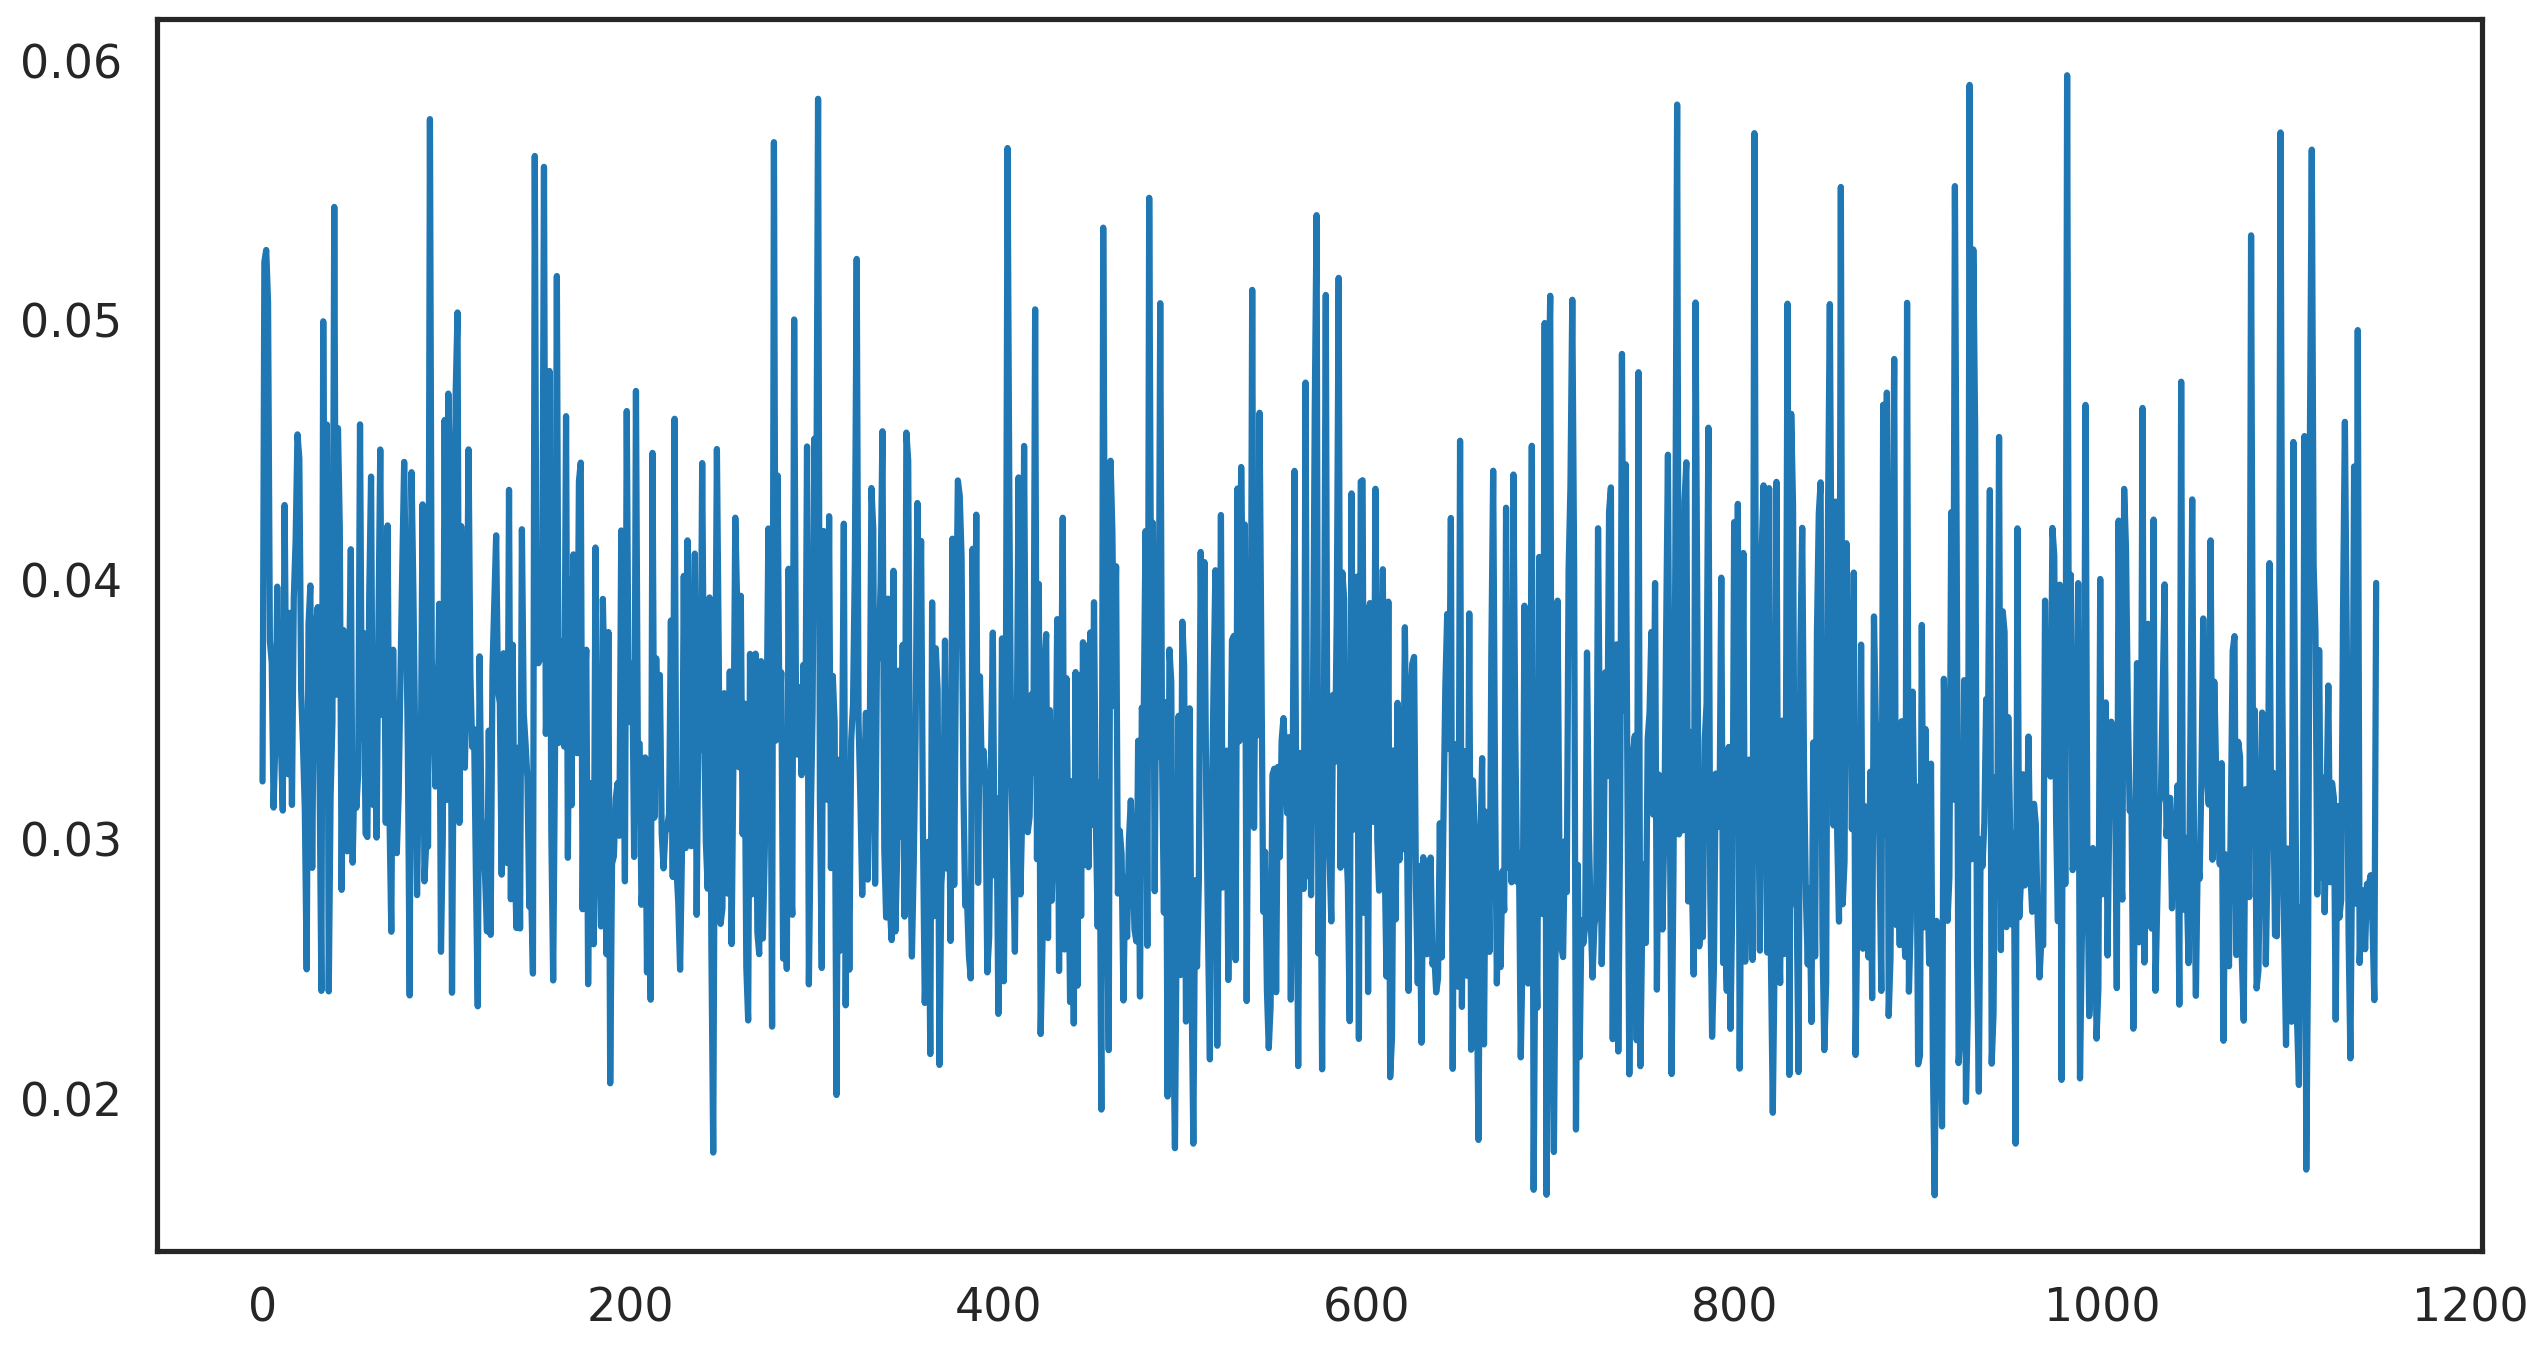

In [ ]:
from copy import deepcopy
from random import random

top = deepcopy(trained_reasoner.top_concept)
bot = deepcopy(trained_reasoner.bot_concept)
sub_nn = deepcopy(trained_reasoner.sub_nn)
and_nn = nn.Linear(120, 10)


not_nn = deepcopy(trained_reasoner.not_nn)

optimizer = T.optim.AdamW( [{'params': and_nn.parameters()},
                            {'params': not_nn.parameters()},
                            ], 0.0001)
losses = []
maxes = []
criterion = CustomLoss()

for i in range(12001):
    optimizer.zero_grad()

    encoder = encoders[int(np.round(random() * (len(encoders ) - 1) , 0))]
    input1 = encoder.concepts[ int(np.round( random() * encoder.n_concepts , 0)-1) ] 

    encoder = encoders[int(np.round(random() * (len(encoders ) - 1) , 0))]
    input2 = encoder.concepts[ int(np.round( random() * encoder.n_concepts , 0)-1) ] 

    encoder = encoders[int(np.round(random() * (len(encoders ) - 1) , 0))]
    input3 = encoder.concepts[ int(np.round( random() * encoder.n_concepts , 0) - 1) ] 


    loss = criterion(y_true=input1, y_pred=and_nn(im_mod(input1,input1)))
    loss += criterion(y_true=input2, y_pred=and_nn(im_mod(input2,input2)))
    loss += criterion(y_true=input3, y_pred=and_nn(im_mod(input3,input3)))

    identity = loss.item()

    loss += criterion(y_true=and_nn(im_mod(input1, and_nn(im_mod(input2, input3)))),y_pred= and_nn( im_mod (and_nn(im_mod(input1,input2)), input3 ) ))
    loss += criterion(y_true=and_nn(im_mod(input2, and_nn(im_mod(input1, input3)))),y_pred= and_nn( im_mod (and_nn(im_mod(input1,input2)), input3 ) ))
    loss += criterion(y_true=and_nn(im_mod(input3, and_nn(im_mod(input1, input2)))),y_pred= and_nn( im_mod (and_nn(im_mod(input3,input2)), input1 ) ))
    
    rozdzielnosc = (loss - identity).item()

    loss += criterion(y_true=and_nn(im_mod(input1,input3)) ,y_pred= and_nn(im_mod(input3,input1)))
    loss += criterion(y_true=and_nn(im_mod(input3,input2)) ,y_pred= and_nn(im_mod(input2,input3)))
    loss += criterion(y_true=and_nn(im_mod(input2,input1)) , y_pred=and_nn(im_mod(input1,input2)))

    odwrocenie = (loss - rozdzielnosc - identity).item()

    # loss += F.mse_loss(and_nn(im_mod(input1,not_nn(input1))), and_nn(im_mod(input2,not_nn(input2)))).item()
    # loss += F.mse_loss(and_nn(im_mod(input2,not_nn(input2))), and_nn(im_mod(input3,not_nn(input3)))).item()
    # loss += F.mse_loss(and_nn(im_mod(input1,not_nn(input1))), and_nn(im_mod(input3,not_nn(input3)))).item()

    # modelowanie_bot = loss - odwrocenie - rozdzielnosc - identity

    x = [identity ,rozdzielnosc , odwrocenie ]
    loss += criterion(y_true=input1, y_pred=not_nn(not_nn(input1)))


    # loss += F.mse_loss(input1, and_nn(im_mod(input1,top[0]))).item()
    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input2))).item()
    # loss += F.mse_loss(input3, and_nn(im_mod(input3,top[0]))).item()

    # loss += F.mse_loss(bot[0], and_nn(im_mod(input1,bot[0]))).item()
    # loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0],input2))).item()
    # loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input3))).item()
    # loss += F.mse_loss(bot[0], and_nn(im_mod(top[0], bot[0]))).item()

    if i>500:
        if i%10 == 0:
            losses.append(loss.item())
            maxes.append([np.argmax(x), np.max(x)])
    if i%1000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

import matplotlib.pyplot as plt

plt.plot(losses)


In [ ]:
criterion = F.mse_loss
encoder = encoders[int(np.round(random() * (len(encoders ) - 1) , 0))]
input1 = encoder.concepts[ int(np.round( random() * encoder.n_concepts , 0)-1) ] 

encoder = encoders[int(np.round(random() * (len(encoders ) - 1) , 0))]
input2 = encoder.concepts[ int(np.round( random() * encoder.n_concepts , 0)-1) ] 

encoder = encoders[int(np.round(random() * (len(encoders ) - 1) , 0))]
input3 = encoder.concepts[ int(np.round( random() * encoder.n_concepts , 0) - 1) ] 


loss = criterion(input1, and_nn(im_mod(input1,input1)))
loss += criterion(input2, and_nn(im_mod(input2,input2)))
loss += criterion(input3, and_nn(im_mod(input3,input3)))

identity = loss.item()

loss += criterion(and_nn(im_mod(input1, and_nn(im_mod(input2, input3)))), and_nn( im_mod (and_nn(im_mod(input1,input2)), input3 ) ))
loss += criterion(and_nn(im_mod(input2, and_nn(im_mod(input1, input3)))), and_nn( im_mod (and_nn(im_mod(input1,input2)), input3 ) ))
loss += criterion(and_nn(im_mod(input3, and_nn(im_mod(input1, input2)))), and_nn( im_mod (and_nn(im_mod(input3,input2)), input1 ) ))

print(loss)

tensor(0.0396, grad_fn=<AddBackward0>)
